# New York Dataset

In [1]:
import re
import pandas as pd

In [2]:
ny_df = pd.read_csv("/kaggle/input/ml-reboot/new_york.csv", index_col = 0)

In [3]:
# Define a function to extract numbers from strings
def extract_number(text):
    try:
        # Use regular expressions to extract numeric values from strings
        return float(re.search(r'\d+\.\d+', str(text)).group())
    except AttributeError:
        return None  # Return None for non-numeric values

# Define a list of interesting columns
interesting_cols = ["price", "bathrooms_text", "instant_bookable", "room_type"]

def df_cleaner(df):
    copy = df.copy()

    # Remove dollar signs and commas from the "price" column
    copy["price"] = copy["price"].str.replace("$", "").str.replace(",", "").astype(float)

    # Filter the DataFrame based on the price range
    reduced = copy[(copy["price"] > 50) & (copy["price"] < 1500)].copy()

    # Select the relevant columns
    relevant = reduced[interesting_cols].copy()

    # Extract numbers from the "bathrooms_text" column
    relevant['bathrooms_text'] = relevant['bathrooms_text'].apply(extract_number)

    # Map 't' and 'f' in "instant_bookable" to 1 and 0
    relevant['instant_bookable'] = relevant['instant_bookable'].map({'t': 1, 'f': 0})

    # Create dummy variables for "room_type"
    relevant = pd.get_dummies(relevant, columns=['room_type'])

    # Drop rows with missing values
    clean_df = relevant.dropna()

    return clean_df

In [4]:
clean_ny = df_cleaner(ny_df)

In [5]:
ny_X = clean_ny.drop("price", axis = 1)
ny_y = clean_ny["price"]

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
ny_X_train, ny_X_test, ny_y_train, ny_y_test = train_test_split(ny_X, ny_y, test_size=0.2, random_state=42)

In [8]:
ny_mean = ny_y_train.mean()
ny_baseline = ((ny_y_test - ny_mean)**2).mean()
ny_baseline

74076.21505826812

In [9]:
from sklearn.preprocessing import RobustScaler

In [10]:
ny_scaler = RobustScaler()
ny_X_scaled = ny_scaler.fit_transform(ny_X_train)

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
from sklearn.neighbors import KNeighborsRegressor

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
ny_linear_model = LinearRegression()
ny_knn_regressor = KNeighborsRegressor()
ny_rf_model = RandomForestRegressor(random_state = 42)

In [15]:
from sklearn.model_selection import cross_val_score
ny_linear_score = cross_val_score(ny_linear_model, ny_X_scaled, ny_y_train, cv = 5, scoring = "neg_mean_squared_error")
ny_neighbor_score = cross_val_score(ny_knn_regressor, ny_X_scaled, ny_y_train, cv = 5, scoring = "neg_mean_squared_error")
ny_rf_score = cross_val_score(ny_rf_model, ny_X_scaled, ny_y_train, cv = 5, scoring = "neg_mean_squared_error")

In [16]:
print(ny_linear_score.mean(), ny_neighbor_score.mean(), ny_rf_score.mean())

-1.5333524113433811e+28 -33091.06302458964 -30480.76037465203


In [17]:
ny_rf_model.fit(ny_X_scaled, ny_y_train)

RandomForestRegressor(random_state=42)

In [18]:
ny_X_test_scaled = ny_scaler.transform(ny_X_test)

In [19]:
ny_rf_pred = ny_rf_model.predict(ny_X_test_scaled)

In [20]:
from sklearn.metrics import mean_squared_error

In [21]:
ny_rf_mse = mean_squared_error(ny_y_test, ny_rf_pred)

# K-Means Clustering

In [22]:
locations = ny_df[["latitude", "longitude"]].copy()

In [23]:
from sklearn.cluster import KMeans

In [24]:
k_model = KMeans(n_clusters = 5)

In [25]:
k_model.fit(locations)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [26]:
locations["labels"] = k_model.labels_ 

In [27]:
locations

,latitude,longitude,labels
0,40.753560,-73.985590,0
1,40.685350,-73.955120,3
2,40.662650,-73.994540,2
3,40.764570,-73.983170,0
4,40.803800,-73.967510,4
...,...,...,...
37405,40.631656,-74.094878,2
37406,40.717840,-73.951610,3
37407,40.735540,-73.987880,0
37408,40.729638,-73.987644,0


<Axes: xlabel='longitude', ylabel='latitude'>

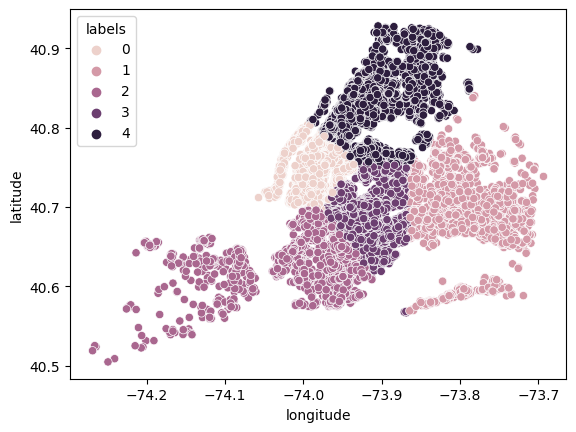

In [28]:
import seaborn as sns
sns.scatterplot(data = locations, x ="longitude", y = "latitude", hue = "labels")